# 임베딩 내 편향성 알아보기

In [18]:
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [20]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

# s(w,A,B)는 개별 단어 w가 개념축 A-B에 대해 가지는 편향성을 계산한 값
# -2 ~ 2의 값
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

# s(X,A,B)평균 - s(Y,A,B)평균을 전체 표준편차로 나눈 값
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [33]:
from gensim.models import Word2Vec

def get_representative_words(token_list, vector_size=100, window=5, min_count=3, sg=0, topn=15):
    """
    Word2Vec을 학습하고 중심 벡터에 가장 가까운 단어 topn개를 반환합니다.
    
    Args:
        token_list (List[List[str]]): 문장 단위 토큰 리스트
        vector_size (int): 임베딩 차원 수
        window (int): 윈도우 크기
        min_count (int): 최소 단어 등장 빈도
        sg (int): 0=CBOW, 1=Skip-gram
        topn (int): 반환할 대표 단어 수
        
    Returns:
        List[str]: 중심 벡터에 가장 가까운 대표 단어 리스트
    """
    
    # Word2Vec 모델 학습
    model = Word2Vec(sentences=token_list, vector_size=vector_size, window=window, min_count=min_count, sg=sg)

    # 중심 벡터 계산
    vector_mean = np.mean([model.wv[word] for word in model.wv.index_to_key], axis=0)

    # 중심 벡터에 가장 가까운 단어 topn개 추출
    representative_words = model.wv.similar_by_vector(vector_mean, topn=topn)
    
    return [word for word, _ in representative_words]

## 1. 명사만 추출 및 embedding model 만들기

In [ ]:
from konlpy.tag import Okt

okt = Okt()

In [23]:
#  형태소 분석기를 이용하여 품사가 명사인 경우, 해당 단어를 추출하기


def read_token(file_name):
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            
            tokenlist = okt.pos(line, stem=True, norm=True) # 어간 추출, 표준화
            for word in tokenlist:
                if word[1] in ["Noun"]:      #, "Adjective", "Verb"]:
                    result.append((word[0])) # 명사일 때만 tokenized 에 저장하게 됩니다. 
                    
    return result

def read_token_to_str(file_name):
    tokens = read_token(file_name)
    return ' '.join(tokens)

### 전체 파일 ###

In [28]:
# 약 15분정도 걸립니다.

tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True) # 어간 추출, 표준화
        # [('오늘', 'Noun'), ('은', 'Josa'), ('날씨', 'Noun'), ('가', 'Josa'), ('정말', 'Adverb'), ('좋다', 'Adjective'), ('!', 'Punctuation')]
        
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print(len(tokenized))

71156


In [29]:
# 전체 문서 파일에 대해서 word embedding 만들기

from gensim.models import Word2Vec

# 1. 토큰 추출하기
all_txt = 'synopsis.txt'
# tokenized = read_token(all_txt)        
print(f'{all_txt}의 토큰: ', len(tokenized))

# 2. 토큰으로 embedding model 만들기
model_all = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  


synopsis.txt의 토큰:  71156


In [30]:
print('Word2Vec 단어 수:', len(model_all.wv))
print('상위 20개 단어:', model_all.wv.index_to_key[:20])

Word2Vec 단어 수: 24320
상위 20개 단어: ['그', '것', '이', '자신', '그녀', '수', '영화제', '제', '위해', '시작', '사람', '날', '국제', '사랑', '영화', '친구', '집', '남자', '알', '속']


In [31]:
model_all.wv.most_similar(positive=['사랑'])

[('만남', 0.6899369955062866),
 ('이별', 0.6877090334892273),
 ('첫사랑', 0.6872538924217224),
 ('행복', 0.6846103072166443),
 ('정일', 0.6842008233070374),
 ('연애', 0.6823093891143799),
 ('만인', 0.6810586452484131),
 ('열정', 0.6636145114898682),
 ('고백', 0.658753514289856),
 ('운명', 0.6568127870559692)]

In [32]:
model_all.wv.most_similar(positive=['영화'])

[('작품', 0.8914897441864014),
 ('다큐멘터리', 0.8577653169631958),
 ('드라마', 0.8312057256698608),
 ('영화로', 0.8121709227561951),
 ('형식', 0.7832354307174683),
 ('코미디', 0.7811157703399658),
 ('주제', 0.7795397639274597),
 ('스토리', 0.771876871585846),
 ('버자이너', 0.7697139382362366),
 ('감동', 0.7692899107933044)]

### target 파일 (art, gen) ###

In [35]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
# 여기서 읽어들인 토큰들은 "중심벡터유사도방식" 사용할 예정임. 
art_tokens = read_token(art_txt) # 리스트 형태로 반환
gen_tokens = read_token(gen_txt)
art_str = ' '.join(art_tokens)   # 리스트를 문자열로 변환
gen_str = ' '.join(gen_tokens)

print(f'{art_txt}의 토큰: ', len(art_tokens))
print(f'{gen_txt}의 토큰: ', len(gen_tokens))

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.
synopsis_art.txt의 토큰:  208471
synopsis_gen.txt의 토큰:  1008358


### 모든 장르 파일 ###

In [40]:
#4. 모든 장르의 대표 단어를 추출 
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']


# 1). 토큰 추출하기
genre_tokens_dict = {}
genre_all_str = []

for file_name, name in zip(genre_txt, genre_name):
    tokens = read_token(file_name)
    
    rep_words = get_representative_words(tokens)  # 중심단어 추출
    genre_tokens_dict[name] = {
        'tokens': tokens,
        'representative_words': rep_words
    }
      
    genre_all_str.append(' '.join(tokens))
    

    
# 2) 결과 확인
for genre, data in genre_tokens_dict.items():
    print(f'{genre} 장르의 토큰 수:', len(data['tokens']))
    print(f'  대표 단어: {data["representative_words"][:15]}')  # 일부만 출력

print('\n전체 통합 토큰 수:', len(genre_all_str))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.
SF 장르의 토큰 수: 21712
  대표 단어: ['티', '오', '디', '코', '수', '턴', '브', '만', '노', '라', '분', '드', '에', '어', '트']
가족 장르의 토큰 수: 8006
  대표 단어: ['스', '리', '이', '기', '마', '트', '가', '로', '드', '자', '사', '모', '인', '지', '아']
공연 장르의 토큰 수: 7984
  대표 단어: ['스', '리', '르', '이', '마', '로', '트', '아', '레', '피', '지', '인', '라', 

## 2. TF-IDF를 이용한 단어셋 추출 방법

In [36]:
# 3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art_str, gen_str])

print(X.shape)

m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다.

#상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

print(w1_)
print(w2_)
    
# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model_all.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model_all.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

print('target_art :', target_art)
print('target_get :', target_gen)

(2, 41082)
['그녀', '자신', '시작', '위해', '사랑', '사람', '영화', '친구', '남자', '가족', '이야기', '마을', '사건', '마음', '세상', '아버지', '아이', '엄마', '모든', '여자', '대한', '서로', '과연', '다시', '시간', '아들', '소녀', '아내', '다른', '사이', '영화제', '세계', '사실', '하나', '점점', '남편', '감독', '여행', '인생', '발견', '모두', '순간', '우리', '가장', '마지막', '생활', '아빠', '모습', '통해', '죽음', '기억', '비밀', '학교', '음악', '한편', '소년', '생각', '도시', '명의', '사고', '결혼', '전쟁', '때문', '위기', '이제', '최고', '이자', '과거', '일상', '경찰', '상황', '간다', '미국', '결심', '운명', '현실', '관계', '지금', '단편', '여인', '하루', '이름', '이후', '준비', '인간', '감정', '만난', '국제', '처음', '충격', '살인', '누구', '동안', '존재', '그린', '어머니', '연인', '계속', '동생', '작품']
['자신', '그녀', '영화제', '위해', '사람', '시작', '국제', '영화', '친구', '사랑', '남자', '이야기', '대한', '서울', '여자', '사건', '남편', '아이', '가족', '아버지', '다른', '마을', '시간', '엄마', '아들', '모든', '단편', '마음', '사실', '다시', '세계', '모습', '작품', '통해', '생각', '서로', '세상', '발견', '감독', '아내', '관계', '소녀', '사이', '하나', '우리', '애니메이션', '때문', '여성', '죽음', '과연', '점점', '인간', '생활', '한편', '결혼', '상황', '모두', '기억', '명의', '소년', '여행', '가장', '간다'

In [44]:
# 2). TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
vectorizer_g = TfidfVectorizer()
X_g = vectorizer_g.fit_transform(genre_all_str)

print(X_g.shape)


m = [X_g[i].tocoo() for i in range(X_g.shape[0])] # TF-IDF로 표현한 sparse matrix list를 가져옵니다

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]


for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True) #단어들을 TF-IDF가 높은 순으로 정렬합니다.
    
    
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer_g.get_feature_names()[w[i][j][0]] in model_all.wv:
            attr.append(vectorizer_g.get_feature_names()[w[i][j][0]])
        j += 1
    print( attr)
    attributes.append(attr)
    print()

# <-- 장르마다 중복된 단어 있음

(21, 42191)
SF: ['위해', '자신', '지구', '시작', '사람', '인류', '인간', '미래', '우주', '그녀', '로봇', '세계', '모든', '박사', '우주선']

가족: ['엄마', '아빠', '가족', '영화제', '자신', '위해', '친구', '아주르', '아버지', '시작', '그녀', '아들', '마을', '국제', '낙타']

공연: ['오페라', '사랑', '토스카', '실황', '올레', '자신', '카바', '그녀', '공연', '오텔로', '리골레토', '백작', '프레', '베르디', '위해']

공포(호러): ['시작', '위해', '사람', '자신', '친구', '그녀', '사건', '공포', '발견', '죽음', '마을', '가족', '악령', '남자', '좀비']

기타: ['영화제', '국제', '서울', '단편', '영화', '자신', '사람', '이야기', '그녀', '남자', '위해', '시작', '사랑', '뉴미디어', '페스티벌']

다큐멘터리: ['영화제', '영화', '다큐', '국제', '다큐멘터리', '사람', '이야기', '대한', '자신', '감독', '위해', '서울', '우리', '시작', '세계']

드라마: ['자신', '영화제', '그녀', '사람', '사랑', '영화', '위해', '시작', '국제', '남자', '친구', '이야기', '엄마', '여자', '아버지']

멜로로맨스: ['그녀', '사랑', '자신', '시작', '남편', '남자', '여자', '사람', '친구', '섹스', '위해', '마음', '결혼', '서로', '아내']

뮤지컬: ['뮤지컬', '사랑', '에스메랄다', '그녀', '음악', '충무로', '모차르트', '영화', '토스카', '자신', '니웨', '카바', '영화제', '바흐', '페뷔스']

미스터리: ['사건', '그녀', '시작', '자신', '위해', '사람', '발견', '사고', '진실', '죽음', '기억', '살인',

In [ ]:
# 5. embedding model과 단어 셋으로 WEAT score 구해보기

#target_X 는 art, target_Y 는 gen으로 고정하고 attribute_A, attribute_B를 바꿔가면서 구해봅시다. 
# 구한 결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담아봅시다.
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]


X = np.array([model_all.wv[word] for word in target_art])
Y = np.array([model_all.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model_all.wv[word] for word in attributes[i]])
        B = np.array([model_all.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

In [52]:
def compute_weat_matrix(genre_names, attribute_sets, target_art, target_gen, model, verbose=True):
    """
    장르 쌍 간 WEAT 점수를 계산하는 행렬을 반환합니다.
    
    Args:
        genre_names (List[str]): 장르 이름 리스트
        attribute_sets (Dict[str, List[str]]): 각 장르에 대한 속성 단어 리스트
        target_art (List[str]): 예술영화 대표 단어 리스트
        target_gen (List[str]): 일반영화 대표 단어 리스트
        model (gensim Word2Vec): 학습된 Word2Vec 모델
        weat_score_fn (function): WEAT 점수를 계산하는 함수
        verbose (bool): True일 경우 결과를 출력

    Returns:
        matrix (2D List[float]): 장르 쌍 간 WEAT 점수 행렬 (대각선 위 삼각형만 사용)
    """

    n = len(genre_names)
    matrix = [[0 for _ in range(n)] for _ in range(n)]

    # X, Y는 고정된 target (예술, 일반 영화)
    X = np.array([model.wv[word] for word in target_art if word in model.wv])
    Y = np.array([model.wv[word] for word in target_gen if word in model.wv])

    for i in range(n - 1):
        for j in range(i + 1, n):
            #A_words = [w for w in attribute_sets[genre_names[i]] if w in model.wv]
            #B_words = [w for w in attribute_sets[genre_names[j]] if w in model.wv]

           # if not A_words or not B_words:
           #     matrix[i][j] = None  # 단어가 없으면 계산 불가
           #     continue

           # A = np.array([model.wv[word] for word in A_words])
            #B = np.array([model.wv[word] for word in B_words])
            A = np.array([model_all.wv[word] for word in attributes[i]])
            B = np.array([model_all.wv[word] for word in attributes[j]])
            
            score = weat_score(X, Y, A, B)
            matrix[i][j] = score

            if verbose:
                print(f"예술영화 vs 상업영화 | {genre_names[i]} vs {genre_names[j]}: WEAT score = {score:.4f}")

    return matrix

In [53]:

matrix_tfidf = compute_weat_matrix(
    genre_names=genre_name,
    #attribute_sets={g: genre_tokens_dict[g]['representative_words'] for g in genre_name},
    attribute_sets=attributes, # TF-IDF로 추출한 단어들
    target_art=target_art,
    target_gen=target_gen,
    model=model_all
)

예술영화 vs 상업영화 | SF vs 가족: WEAT score = -0.5133
예술영화 vs 상업영화 | SF vs 공연: WEAT score = -0.3624
예술영화 vs 상업영화 | SF vs 공포(호러): WEAT score = -0.6788
예술영화 vs 상업영화 | SF vs 기타: WEAT score = 0.3511
예술영화 vs 상업영화 | SF vs 다큐멘터리: WEAT score = 0.5950
예술영화 vs 상업영화 | SF vs 드라마: WEAT score = -0.3644
예술영화 vs 상업영화 | SF vs 멜로로맨스: WEAT score = -0.7948
예술영화 vs 상업영화 | SF vs 뮤지컬: WEAT score = 0.3435
예술영화 vs 상업영화 | SF vs 미스터리: WEAT score = -0.6950
예술영화 vs 상업영화 | SF vs 범죄: WEAT score = -0.2420
예술영화 vs 상업영화 | SF vs 사극: WEAT score = -0.8704
예술영화 vs 상업영화 | SF vs 서부극(웨스턴): WEAT score = -0.4199
예술영화 vs 상업영화 | SF vs 성인물(에로): WEAT score = -0.5729
예술영화 vs 상업영화 | SF vs 스릴러: WEAT score = -0.5297
예술영화 vs 상업영화 | SF vs 애니메이션: WEAT score = 0.3895
예술영화 vs 상업영화 | SF vs 액션: WEAT score = -0.4859
예술영화 vs 상업영화 | SF vs 어드벤처: WEAT score = -0.8109
예술영화 vs 상업영화 | SF vs 전쟁: WEAT score = 0.1898
예술영화 vs 상업영화 | SF vs 코미디: WEAT score = -0.4537
예술영화 vs 상업영화 | SF vs 판타지: WEAT score = -0.1743
예술영화 vs 상업영화 | 가족 vs 공연: WEAT score = 0.2231
예술영화 vs

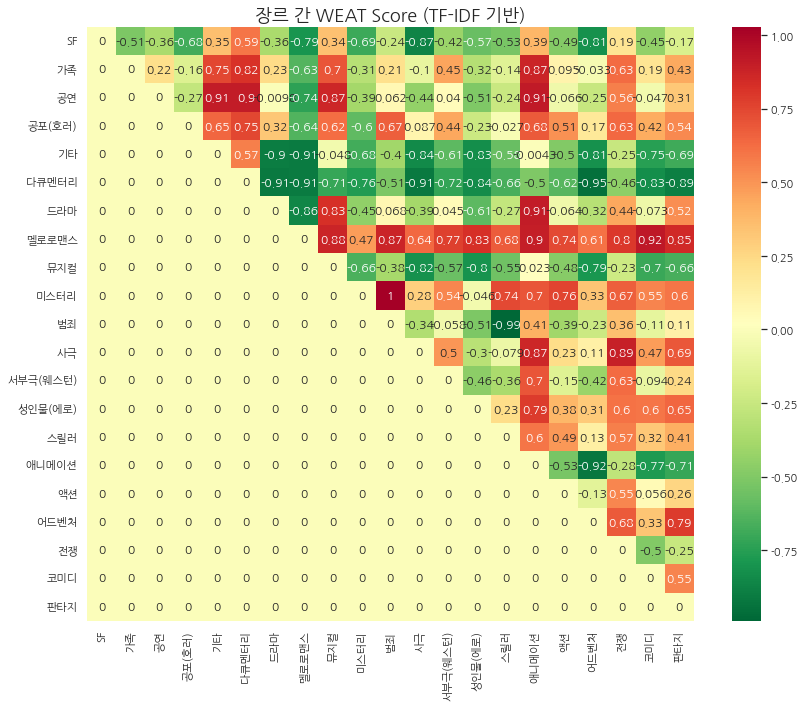

<Figure size 432x288 with 0 Axes>

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12, 10))

ax = sns.heatmap(matrix_tfidf, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
#ax

plt.title('장르 간 WEAT Score (TF-IDF 기반)', fontsize=18)
plt.tight_layout()
plt.show()

plt.savefig('weat_score_heatmap_tfidf.png', dpi=100, bbox_inches='tight')

## 3. 중심벡터 유사도 방식으로  단어셋 추출

In [ ]:
target_art_2, target_gen_2 = [], []

# 토큰으로 embedding model 만들기
model_art = Word2Vec(art_tokens, vector_size=100, window=5, min_count=3, sg=0) 
# 중심 벡터
vector_mean = np.mean([model_art.wv[word] for word in model_art.wv.index_to_key], axis=0)

# 중심 벡터에 가장 가까운 단어들
representative_words = model_art.wv.similar_by_vector(vector_mean, topn=20)
target_art_2 = [word for word, _ in representative_words]
print("art 대표 단어:", target_art_2)



In [62]:

# 대표 단어 추출
target_art_2 = get_representative_words(art_tokens)
target_gen_2 = get_representative_words(gen_tokens)

print("예술영화 대표 단어:", target_art_2)
print("상업영화 대표 단어:", target_gen_2)

예술영화 대표 단어: ['컥', '샅', '꿋', '떡', '빡', '갬', '흠', '앳', '틈', '쿵', '볕', '잎', '웠', '톰', '뮈']
상업영화 대표 단어: ['끙', '넵', '쏙', '킵', '쉿', '짹', '빽', '튠', '츤', '얍', '낄', '끗', '떵', '찹', '쩔']


In [64]:
attribute_sets = []
attribute_sets = {g: genre_tokens_dict[g]['representative_words'] for g in genre_name}

matrix_meanvt = compute_weat_matrix(
    genre_names=genre_name,
    attribute_sets=attribute_sets, # 중심벡터 유사도로 추출한 단어들
    target_art=target_art_2,
    target_gen=target_gen_2,
    model=model_all
)

예술영화 vs 상업영화 | SF vs 가족: WEAT score = -0.3026
예술영화 vs 상업영화 | SF vs 공연: WEAT score = 0.0086
예술영화 vs 상업영화 | SF vs 공포(호러): WEAT score = -1.0345
예술영화 vs 상업영화 | SF vs 기타: WEAT score = 0.4869
예술영화 vs 상업영화 | SF vs 다큐멘터리: WEAT score = 0.3711
예술영화 vs 상업영화 | SF vs 드라마: WEAT score = -0.2966
예술영화 vs 상업영화 | SF vs 멜로로맨스: WEAT score = -0.5312
예술영화 vs 상업영화 | SF vs 뮤지컬: WEAT score = 0.3015
예술영화 vs 상업영화 | SF vs 미스터리: WEAT score = -0.8755
예술영화 vs 상업영화 | SF vs 범죄: WEAT score = -0.3944
예술영화 vs 상업영화 | SF vs 사극: WEAT score = -0.6703
예술영화 vs 상업영화 | SF vs 서부극(웨스턴): WEAT score = -0.7997
예술영화 vs 상업영화 | SF vs 성인물(에로): WEAT score = -0.4270
예술영화 vs 상업영화 | SF vs 스릴러: WEAT score = -0.7424
예술영화 vs 상업영화 | SF vs 애니메이션: WEAT score = 0.4195
예술영화 vs 상업영화 | SF vs 액션: WEAT score = -0.6275
예술영화 vs 상업영화 | SF vs 어드벤처: WEAT score = -1.0484
예술영화 vs 상업영화 | SF vs 전쟁: WEAT score = 0.2521
예술영화 vs 상업영화 | SF vs 코미디: WEAT score = -0.7639
예술영화 vs 상업영화 | SF vs 판타지: WEAT score = -0.4644
예술영화 vs 상업영화 | 가족 vs 공연: WEAT score = 0.6719
예술영화 vs 

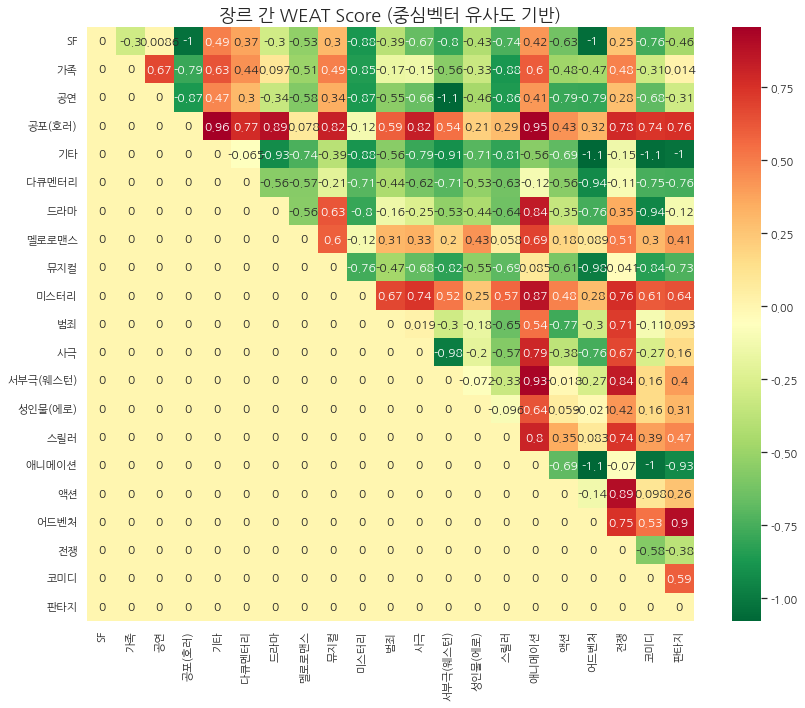

<Figure size 432x288 with 0 Axes>

In [67]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12, 10))

ax = sns.heatmap(matrix_meanvt, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')


plt.title('장르 간 WEAT Score (중심벡터 유사도 기반)', fontsize=18)
plt.tight_layout()
plt.show()

plt.savefig('weat_score_heatmap_meanvt.png', dpi=100, bbox_inches='tight')

## 4. 잠재 의미 분석(Latent Semantic Analysis, LSA)

In [68]:
def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-n - 1:-1]])

In [69]:
def get_top_words_from_first_topic(components, feature_names, n=15):
    first_topic = components[0]
    top_indices = first_topic.argsort()[:-n - 1:-1]
    top_words = [(feature_names[i], round(first_topic[i], 5)) for i in top_indices]
    return top_words

In [1]:
from sklearn.decomposition import TruncatedSVD

# X
# X_g
print('target TF-IDF 행렬의 크기 :',X.shape)


svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X)
print('target :', len(svd_model.components_)) # LSA에서 VT


terms = vectorizer.get_feature_names() # 단어 집합
top_words_topic1 = get_top_words_from_first_topic(svd_model.components_, terms)

# 결과 출력
print("Top 15 words in Topic 1:")
for word, score in top_words_topic1:
    print(f"{word}: {score}")

NameError: name 'X' is not defined

In [ ]:
print('attribute TF-IDF 행렬의 크기 :',X_g.shape)
svd_model_g = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)
svd_model_g.fit(X_g)
print('target :', len(svd_model_g.components_))